In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
from process import Data_process

In [2]:
t = Data_process(r'dataset\01_tracks.csv')
allinfo = t.distance_selector()[t.time_selecter().index[0]]
for i in range(1, len(t.time_selecter())):
    allinfo = pd.concat([allinfo, t.distance_selector()[t.time_selecter().index[i]]], axis=0)

In [5]:
# 按frame列大小从小到大进行排序
df_sorted = allinfo.sort_values(by='frame')

# 保留每个following_id的前375行
df_top10 = df_sorted.groupby('following_id').head(375)

# 提取除去front_id和follow_id的列
df_features = df_top10.drop(columns=['front_id', 'following_id', 'frame', 'following_x', 'front_x'], )

# 计算不同following_id的数量
num_following_ids = df_top10['following_id'].nunique()

# 提取数据框的值，并转换为三维数组
data_array = df_features.values.reshape(num_following_ids,375,  -1)

# 输出三维数组的形状
print("三维数组的形状:", data_array.shape)

三维数组的形状: (40, 375, 5)


In [15]:
loss_array=[]
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.cluster import KMeans

class LSTMEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTMEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Return the final hidden state
        return out[:, -1, :]


class LSTMDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hx, cx):
        # Forward propagate LSTM
        out, _ = self.lstm(x, (hx, cx))

        # Decode the hidden state to the output space
        out = self.fc(out)

        return out


# Convert data to PyTorch tensor
data_tensor = torch.tensor(data_array, dtype=torch.float32)

# Normalize data
data_mean = torch.mean(data_tensor, dim=(0, 1), keepdim=True)
data_std = torch.std(data_tensor, dim=(0, 1), keepdim=True)
data_tensor = (data_tensor - data_mean) / data_std

# Define model parameters
input_size = 5
hidden_size = 64
output_size = 5
num_layers = 1

# Initialize encoder and decoder
encoder = LSTMEncoder(input_size, hidden_size, num_layers)
decoder = LSTMDecoder(input_size, hidden_size, output_size, num_layers)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)


# Training
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    encoded = encoder(data_tensor)
    # Get the last hidden state of the encoder as initial hidden state for decoder
    hx, cx = encoded.unsqueeze(0), torch.zeros_like(encoded).unsqueeze(0)
    decoded = decoder(data_tensor, hx, cx)
    
    # Compute loss
    loss = criterion(decoded, data_tensor)
    loss_array.append(loss.item())
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    if loss < 0.001:
        break
# Get encoded representation of data
encoded_data = encoder(data_tensor).detach().numpy()

# Perform KMeans clustering on encoded data
kmeans = KMeans(n_clusters=3)  # You can adjust the number of clusters as needed
kmeans.fit(encoded_data)

cluster_labels = kmeans.labels_

print("Cluster labels:", cluster_labels)



Epoch [10/1000], Loss: 0.9507
Epoch [20/1000], Loss: 0.8323
Epoch [30/1000], Loss: 0.6705
Epoch [40/1000], Loss: 0.6171
Epoch [50/1000], Loss: 0.5711
Epoch [60/1000], Loss: 0.5086
Epoch [70/1000], Loss: 0.4362
Epoch [80/1000], Loss: 0.3670
Epoch [90/1000], Loss: 0.2926
Epoch [100/1000], Loss: 0.2186
Epoch [110/1000], Loss: 0.1550
Epoch [120/1000], Loss: 0.1078
Epoch [130/1000], Loss: 0.0780
Epoch [140/1000], Loss: 0.0610
Epoch [150/1000], Loss: 0.0502
Epoch [160/1000], Loss: 0.0416
Epoch [170/1000], Loss: 0.0343
Epoch [180/1000], Loss: 0.0278
Epoch [190/1000], Loss: 0.0222
Epoch [200/1000], Loss: 0.0175
Epoch [210/1000], Loss: 0.0139
Epoch [220/1000], Loss: 0.0112
Epoch [230/1000], Loss: 0.0093
Epoch [240/1000], Loss: 0.0078
Epoch [250/1000], Loss: 0.0068
Epoch [260/1000], Loss: 0.0060
Epoch [270/1000], Loss: 0.0055
Epoch [280/1000], Loss: 0.0051
Epoch [290/1000], Loss: 0.0047
Epoch [300/1000], Loss: 0.0044
Epoch [310/1000], Loss: 0.0042
Epoch [320/1000], Loss: 0.0040
Epoch [330/1000],

d:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Cluster labels: [2 2 2 2 2 0 0 0 0 0 0 1 2 2 0 1 1 0 1 1 0 0 0 1 0 1 1 1 0 0 0 0 2 0 0 0 0
 2 2 2]


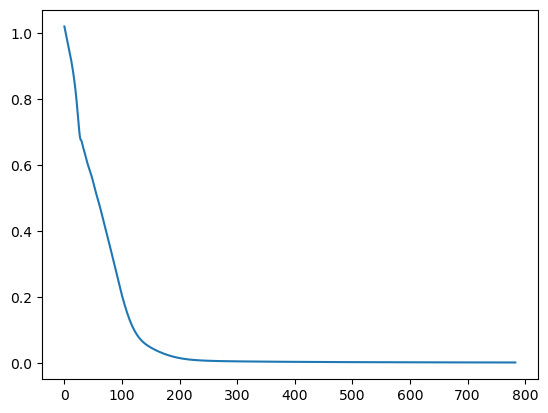

In [14]:
[1 1 2 2 2 1 1 1 1 1 1 0 1 2 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 1 1 1 2 1 0 0 1
 2 2 2]
[2 2 2 2 2 0 0 0 0 0 0 1 2 2 0 1 1 0 1 1 0 0 0 1 0 1 1 1 0 0 0 0 2 0 0 0 0
 2 2 2]